In [1]:
import os
import sys
import random

import yaml
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap

sys.path.append(os.path.join('..', '..', 'tta_uia_segmentation', 'src'))

from dataset.dataset_in_memory_for_ddpm import get_datasets

def plot_img_seg(img, seg, n_classes=14, img_title='Image', seg_title='Segmentation', figsize=(10, 5)):
    if seg.max() <= 1.0:
        seg = seg * (n_classes - 1)
    
    plt.figure(figsize=figsize)
    ax = plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray', interpolation='none', vmin=img.min(), vmax=img.max())
    plt.xticks([])
    plt.yticks([])
    plt.title(img_title)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0)
    plt.colorbar(cax=cax)
    
    ax = plt.subplot(1, 2, 2)
    plt.imshow(seg, vmin=0, vmax=n_classes, cmap='tab20', interpolation='none')
    plt.xticks([])
    plt.yticks([])
    plt.title(seg_title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0)
    plt.colorbar(cax=cax)
    

In [1]:
params_fp               = '/scratch_net/biwidl319/jbermeo/logs/brain/ddpm/not_one_hot_64_base_filters_with_aug_except_noise/params.yaml'
cpt_fp                  = '/scratch_net/biwidl319/jbermeo/logs/brain/ddpm/not_one_hot_64_base_filters_with_aug_except_noise/model-9.pt'
frac_sample_range       = (0.2, 0.8)
dataset                 = 'hcp_t1'
seed                    = 1234 
device                  = 'cpu' if not  torch.cuda.is_available() else 'cuda'
split                   = 'train'
mismatch_mode           = 'none' #'same_patient_very_different_labels'  # 'same_patient_very_different_labels', 'same_patient_similar_labels', 'different_patient_similar_labels', 'none'
n_mismatches            = 4
num_t_samples_per_img   = 20
num_iterations          = 100


np.random.seed(seed)
random.seed(seed)

run_params = yaml.safe_load(open(params_fp, 'r'))
dataset_params = run_params['dataset'][dataset]
training_params = run_params['training']['ddpm']

n_classes = dataset_params['n_classes']

NameError: name 'torch' is not defined

# Let's test each mismatch retrieval mode

In [3]:
(dataset,) = get_datasets(
    norm            = None,
    paths           = dataset_params['paths_processed'],
    paths_original  = dataset_params['paths_original'],
    paths_normalized_h5 = dataset_params['paths_normalized_with_nn'],
    splits          = [split],
    image_size      = training_params['image_size'],
    resolution_proc = dataset_params['resolution_proc'],
    dim_proc        = dataset_params['dim'],
    n_classes       = n_classes,
    aug_params      = None,
    deformation     = None,
    load_original   = True,
    bg_suppression_opts = None,
    one_hot_encode  = False,
)

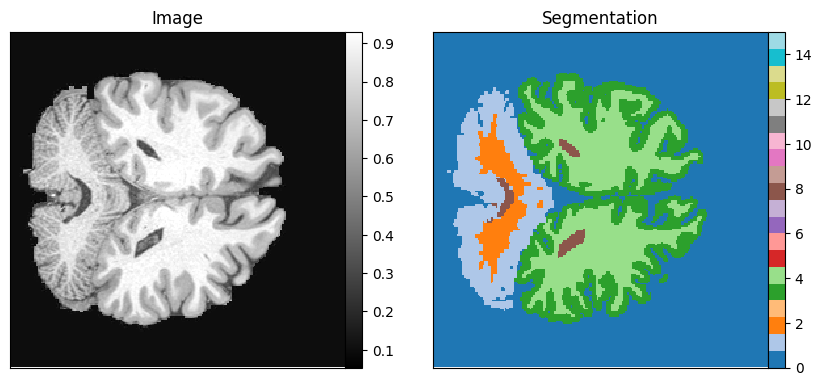

In [4]:
# Sample a random slice
img_size = dataset.image_size[-1]   # DHW
vol_idx = random.randint(0, dataset.num_vols - 1)
slice_idx = random.randint(int(frac_sample_range[0] * img_size),
                            int(frac_sample_range[1] * img_size))
idx = dataset.vol_and_z_idx_to_idx(vol_idx, slice_idx)
img, seg = dataset[idx]

# plot the original image and segmentation
plot_img_seg(img[0], seg[0], n_classes)

## None

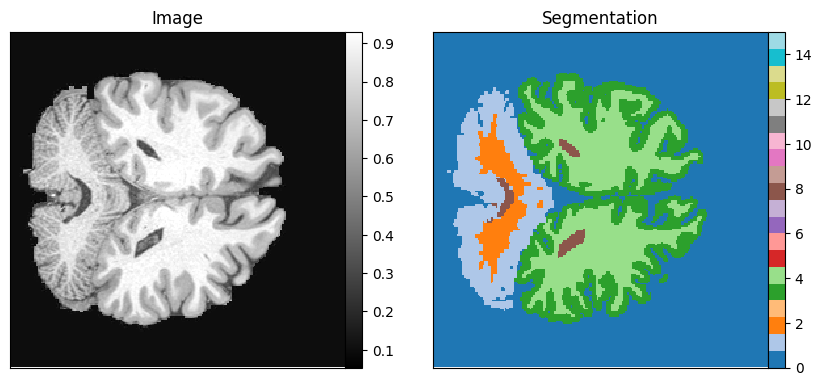

In [5]:
mismatch_ds = dataset.get_related_images(
    vol_idx=vol_idx,
    z_idx=slice_idx,
    mode='none',
    n=n_mismatches
)

for img, seg in mismatch_ds:
    plot_img_seg(img[0], seg[0], n_classes)

## same_patient_very_different_labels

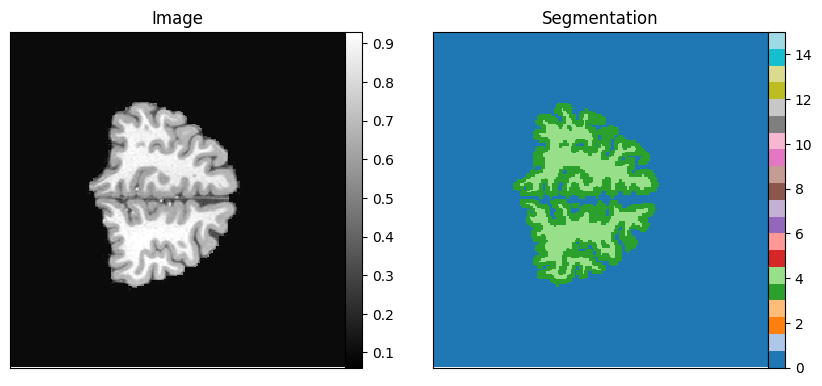

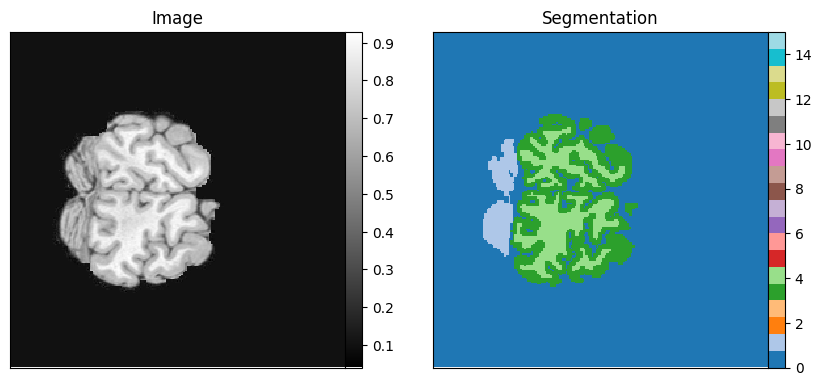

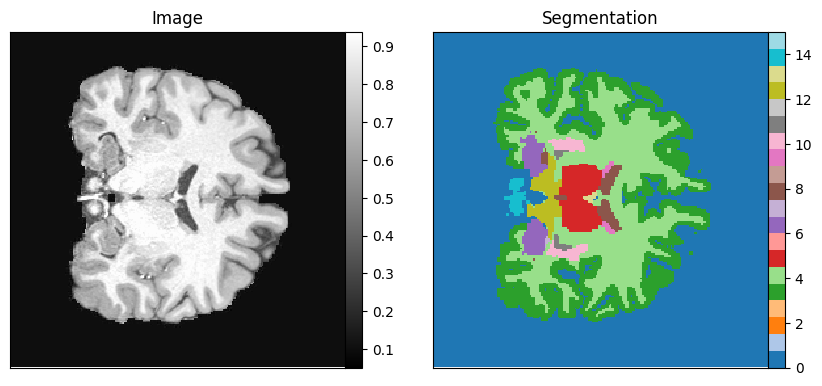

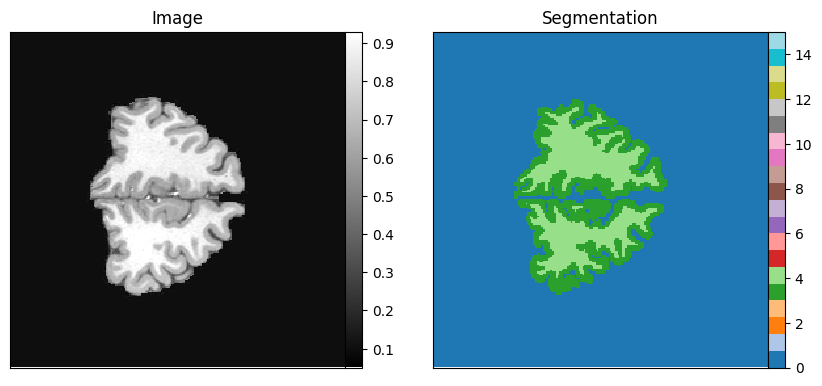

In [6]:
mismatch_ds = dataset.get_related_images(
    vol_idx=vol_idx,
    z_idx=slice_idx,
    mode='same_patient_very_different_labels',
    n=n_mismatches
)

for img, seg in mismatch_ds:
    plot_img_seg(img[0], seg[0], n_classes)

## same_patient_similar_labels


In [7]:
idx_2 = dataset.vol_and_z_idx_to_idx(vol_idx, slice_idx )
_, seg_2 = dataset[idx_2]
seg_2 = (seg_2 * dataset.n_classes).int()

In [8]:
seg = (seg * dataset.n_classes).int()


In [9]:
from torchmetrics.functional.classification import dice

dice(seg_2.squeeze(), seg.squeeze(), ignore_index=0, num_classes=dataset.n_classes)

tensor(0.2768)

Dice score too low to use sample:  tensor(0.3470)
[0. 1. 2. 3. 4. 8.]
[0. 1. 2. 3. 4. 8.]
[ 0.  1.  2.  3.  4.  5.  6.  8. 14.]


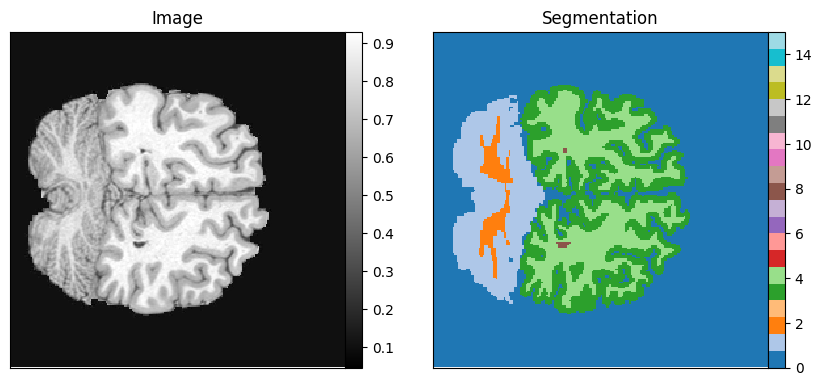

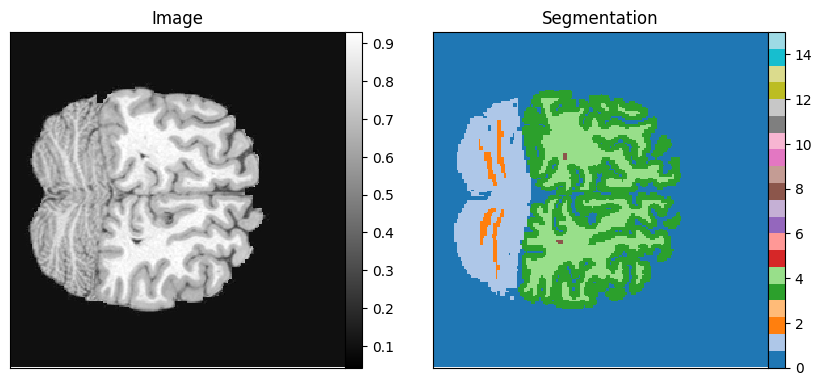

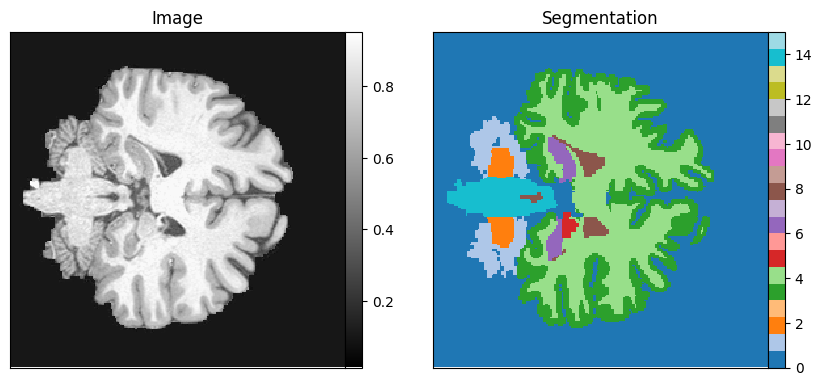

In [10]:
mismatch_ds = dataset.get_related_images(
    vol_idx=vol_idx,
    z_idx=slice_idx,
    mode='same_patient_similar_labels',
    n=n_mismatches,
    min_dice_score_threshold=0.7
)

for img, seg in mismatch_ds:
    print(np.unique(seg * (n_classes - 1)))
    plot_img_seg(img[0], seg[0], n_classes)


## different_patient_similar_labels

In [11]:
n_mismatches

4

vol_idxs_to_sample:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19]
n_slices_per_volume:  {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 1, 13: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0}


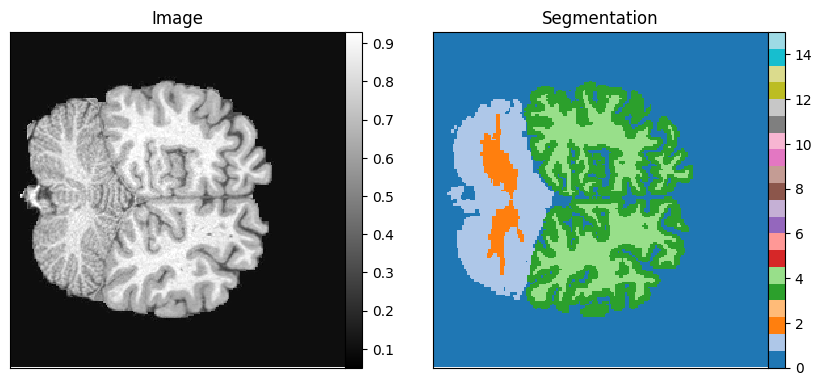

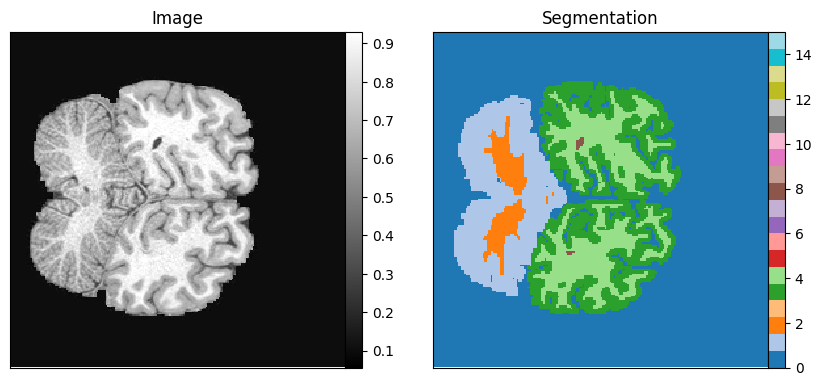

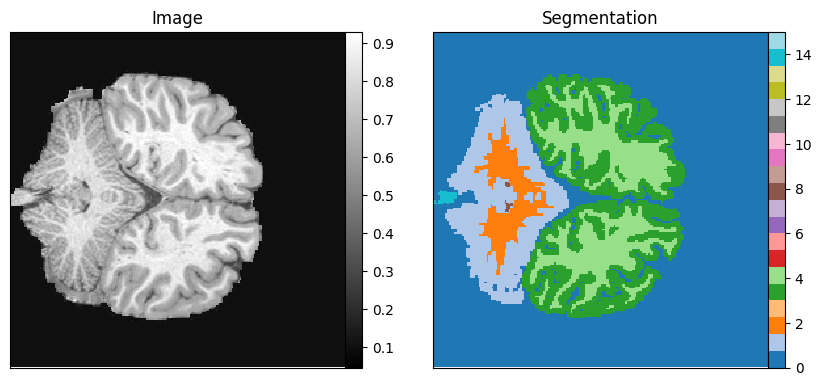

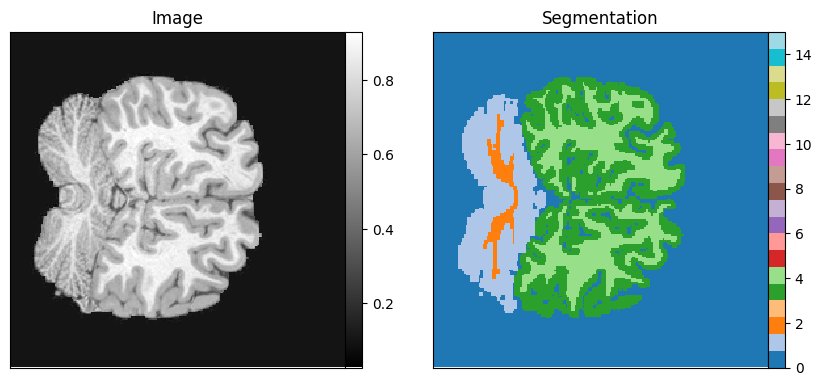

In [12]:
mismatch_ds = dataset.get_related_images(
    vol_idx=vol_idx,
    z_idx=slice_idx,
    mode='different_patient_similar_labels',
    n=n_mismatches,
    max_dist_z_frac=0.2,
    min_dice_score_threshold=0.55
)

for img, seg in mismatch_ds:
    plot_img_seg(img[0], seg[0], n_classes)